In [11]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt

In [12]:
class VPGBuffer():
    def __init__(self, size, obs_dim, act_dim, gamma=0.99, lam=0.95):
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros((size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma = gamma
        self.lam = lam
        self.max_size = size
        self.ptr = 0
        self.traj_start_idx = 0


    def _discount_cumsum(self, x, discount):
        """
        The code below calculates the cummulative discounted sum.
        A more efficient way of doing it, but less readible is the following:
            return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]
        """
        cumsum = np.zeros(len(x), dtype=np.float32)
        cumsum[-1] = x[-1]
        for i in range(len(x) - 2, -1, -1):
            cumsum[i] = x[i] + discount * cumsum[i+1]
        return cumsum
        

    def store(self, obs, act, rew, val, logp):
        assert self.ptr < self.max_size # there must be space in the buffer to store

        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1


    def end_trajectory(self, last_val):
        traj_slice = slice(self.traj_start_idx, self.ptr)
        rews = np.append(self.rew_buf[traj_slice], last_val)
        vals = np.append(self.val_buf[traj_slice], last_val)

        # the next two lines implement GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[traj_slice] = self._discount_cumsum(deltas, self.gamma * self.lam)

        # the next line computes the reward to go
        self.ret_buf[traj_slice] = self._discount_cumsum(rews, self.gamma)[:-1]

        self.traj_start_idx = self.ptr


    def get(self):
        assert self.ptr == self.max_size # buffer must be full

        # reset the buffer
        self.ptr, self.traj_start_idx = 0, 0

        # normalize advantages for training stability
        adv_mean = np.mean(self.adv_buf)
        adv_std = np.std(self.adv_buf)
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std

        data = dict(obs=self.obs_buf, act=self.act_buf, ret=self.ret_buf, adv=self.adv_buf, logp=self.logp_buf)

        # convert data to dict of torch tensors
        data = {k: torch.as_tensor(v, dtype=torch.float32) for k,v in data.items()}

        return data

In [13]:
class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        modules = []
        modules.append(nn.Linear(obs_dim, 256))
        modules.append(nn.ReLU())
        modules.append(nn.Linear(256, 64))
        modules.append(nn.ReLU())
        modules.append(nn.Linear(64, act_dim))

        log_std = -0.5 * np.ones(act_dim, dtype=np.float32)
        self.log_std = torch.nn.Parameter(torch.as_tensor(log_std))
        self.mu_net = nn.Sequential(*modules)


    def _distribution(self, obs):
        mu = self.mu_net(obs)
        std = torch.exp(self.log_std)
        return Normal(mu, std)

    
    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act).sum(axis=-1)    # Last axis sum needed for Torch Normal distribution

    
    def forward(self, obs, act=None):
        # Produce action distributions for given observations, and 
        # optionally compute the log likelihood of given actions under
        # those distributions.
        pi = self._distribution(obs)
        logp_a = None
        if act is not None:
            logp_a = self._log_prob_from_distribution(pi, act)
        return pi, logp_a

In [14]:
class Critic(nn.Module):

    def __init__(self, obs_dim):
        super().__init__()
        modules = []
        modules.append(nn.Linear(obs_dim, 256))
        modules.append(nn.ReLU())
        modules.append(nn.Linear(256, 64))
        modules.append(nn.ReLU())
        modules.append(nn.Linear(64, 1))
        self.v_net = nn.Sequential(*modules)

    def forward(self, obs):
        return torch.squeeze(self.v_net(obs), -1) # Critical to ensure v has right shape.

In [15]:
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()

        self.v = Critic(obs_dim)
        self.pi = Actor(obs_dim, act_dim)

    def step(self, obs):
        with torch.no_grad():
            pi = self.pi._distribution(obs)
            a = pi.sample()
            logp_a = self.pi._log_prob_from_distribution(pi, a)
            v = self.v(obs)
        return a.numpy(), v.numpy(), logp_a.numpy()

    def act(self, obs):
        return self.step(obs)[0]

In [16]:
class VPGAgent():
    def __init__(self, obs_dim, act_dim, gamma=0.99, pi_lr=5e-3, vf_lr=5e-3, lam=0.97, train_v_iters=20, steps_per_epoch=4000):
        
        self.buf = VPGBuffer(steps_per_epoch, obs_dim, act_dim, gamma, lam)

        self.ac = ActorCritic(obs_dim, act_dim)

        # Set up optimizers for policy and value function
        self.pi_optimizer = optim.Adam(self.ac.pi.parameters(), lr=pi_lr)
        self.vf_optimizer = optim.Adam(self.ac.v.parameters(), lr=vf_lr)

        self.steps_per_epoch = steps_per_epoch
        self.train_v_iters = train_v_iters


    def _compute_loss_pi(self, data):
        obs, act, adv, logp_old = data['obs'], data['act'], data['adv'], data['logp']

        # Policy loss
        pi, logp = self.ac.pi(obs, act)
        loss_pi = -(logp * adv).mean() # negative log probability loss

        return loss_pi


    def _compute_loss_v(self, data):
        obs, ret = data['obs'], data['ret']
        return ((self.ac.v(obs) - ret)**2).mean() # MSE  

    def update(self):
        data = self.buf.get()

        # Train policy with a single step of gradient descent
        self.pi_optimizer.zero_grad()
        loss_pi = self._compute_loss_pi(data)
        loss_pi.backward()
        self.pi_optimizer.step()

        for i in range(self.train_v_iters):
            self.vf_optimizer.zero_grad()
            loss_v = self._compute_loss_v(data)
            loss_v.backward()
            self.vf_optimizer.step()

In [17]:
def train(agent, env_name, epochs=200, max_ep_len=1000):
    ep_ret, ep_len = 0, 0
    ep_rets = []
    avg_rets = []
    for epoch in range(epochs):
        env = gym.make(env_name)
        o = env.reset()
        for t in range(agent.steps_per_epoch):
            a, v, logp = agent.ac.step(torch.as_tensor(np.ascontiguousarray(o), dtype=torch.float32).unsqueeze(0))
            a = a.squeeze(0)
            next_o, r, d, _ = env.step(a)
            ep_ret += r
            ep_len += 1

            agent.buf.store(o, a, r, v, logp)

            o = next_o

            timeout = ep_len == max_ep_len
            terminal = d or timeout
            epoch_ended = t == agent.steps_per_epoch - 1

            if terminal or epoch_ended:
                if timeout or epoch_ended:
                    _, v, _ = agent.ac.step(torch.as_tensor(np.ascontiguousarray(o), dtype=torch.float32).unsqueeze(0))
                else:
                    v = 0
                agent.buf.end_trajectory(v)
                ep_rets.append(ep_ret)
                o, ep_ret, ep_len = env.reset(), 0, 0

        agent.update()
        env.close()
        avg_ep_ret = np.mean(ep_rets[-100:])
        avg_rets.append(avg_ep_ret)
        if (epoch + 1) % 10 == 0:
            print('Epoch: ', epoch+1,'avg ep_ret: ', avg_ep_ret, "total num ep: ", len(ep_rets))

    return avg_rets

In [18]:
env_name = "LunarLanderContinuous-v2"
agent = VPGAgent(8, 2)

In [19]:
rets = train(agent, env_name, epochs=500)

Epoch:  10 avg ep_ret:  -108.6451619983744 total num ep:  424
Epoch:  20 avg ep_ret:  -155.63615509523027 total num ep:  706
Epoch:  30 avg ep_ret:  -10.517660625346917 total num ep:  846
Epoch:  40 avg ep_ret:  -10.478946457850189 total num ep:  896
Epoch:  50 avg ep_ret:  1.8516006100877838 total num ep:  949
Epoch:  60 avg ep_ret:  35.14366979722727 total num ep:  1085
Epoch:  70 avg ep_ret:  -2.2713190809327135 total num ep:  1129
Epoch:  80 avg ep_ret:  -66.6157265752813 total num ep:  1170
Epoch:  90 avg ep_ret:  -93.75334962522876 total num ep:  1210
Epoch:  100 avg ep_ret:  -46.63471911176582 total num ep:  1250
Epoch:  110 avg ep_ret:  -1.492982632464869 total num ep:  1307
Epoch:  120 avg ep_ret:  -3.8503365348050202 total num ep:  1348
Epoch:  130 avg ep_ret:  -36.9981265695811 total num ep:  1388
Epoch:  140 avg ep_ret:  -55.34412654085581 total num ep:  1431
Epoch:  150 avg ep_ret:  -45.78025795058443 total num ep:  1471
Epoch:  160 avg ep_ret:  9.936609780031326 total num

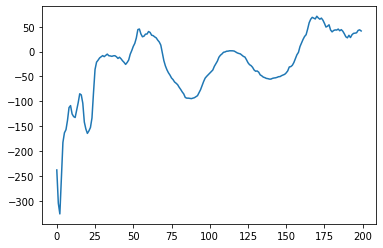

In [20]:
plt.plot([i for i in range(len(rets))], rets)

In [ ]:
def test(agent, env_name, num_games=5):
    env = gym.make(env_name)

    for game in range(num_games):

        obs = env.reset()

        done = False
        while not done:
            act = agent.ac.act(obs)
            obs, rew, done, _ = env.step(act)
            env.render()
            
    env.close()

In [ ]:
test(agent, env_name)